In [1]:
import time
notebook_start = time.time()
%matplotlib nbagg
import matplotlib
import matplotlib.pylab as plt
# import main module
import tiox_jf_utils as tiox

In [2]:
# use predefined image handler (jf instance of the main class JFImages)
jf = tiox.jf

In [3]:
# preload specific file, it finds out indeces of images with beam, with laser without laser, etc.
jf.readJF("../../scan_data/scan162_l04_lxt_mu0p5_xmu_0p3_ybase_13p513_shifted_step0000_JF1p5M.h5")

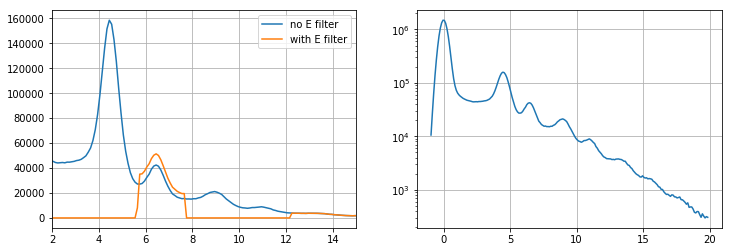

In [4]:
# read and correct one or more images for pedestal and gain
# output of gain correction is in equivalent keV
# if energy_filter is False -> no intensity filter to decrease fluo contribution
imgs_nof = jf.correct(range(10),laser='off',energy_filter=False,expand=False)
imgs_f   = jf.correct(range(10),laser='off',energy_filter=True,expand=False)
# make histogram of readings
counts_nof,bin_edges=np.histogram(imgs_nof.ravel(),np.arange(-1,20,0.1))
counts_f  ,bin_edges=np.histogram(imgs_f.ravel()  ,np.arange(-1,20,0.1))
bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
fig,ax = plt.subplots(1,2,figsize=[12,4])
idx = bin_centers>2
ax[0].plot(bin_centers[idx],counts_nof[idx],label='no E filter')
ax[0].plot(bin_centers[idx],counts_f[idx],label='with E filter')
ax[0].set_xlim(2,15)
ax[1].semilogy(bin_centers,counts_nof)
ax[0].grid()
ax[0].legend()
ax[1].grid()

In [5]:
# in the plot above, increase in one photon elastic peak is due to Energy filtering that removes 4.5 
# from counts around ~11 kev (1 fluo + 1 elastic)

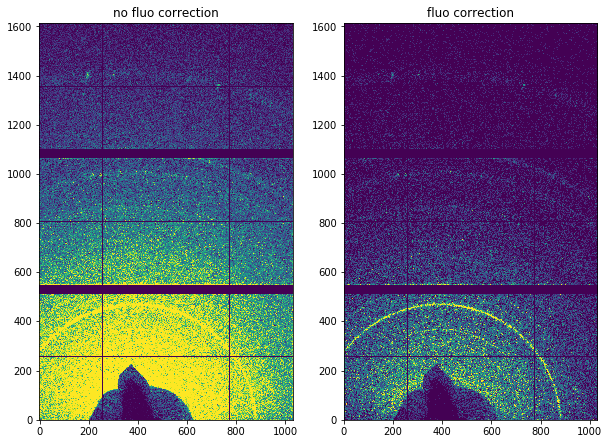

In [6]:
# many counts come from Ti fluo (@ 4.5 keV)
img_nof = jf.correct(range(20),laser='off',energy_filter=False,expand=True).mean(axis=0)
img_f   = jf.correct(range(20),laser='off',energy_filter=True ,expand=True).mean(axis=0)
fig,ax = plt.subplots(1,2,figsize=[10,10])
ax[0].imshow(img_nof,clim=(0,3),origin='bottom')
ax[0].set_title("no fluo correction")
ax[1].imshow(img_f,clim=(0,3),origin='bottom')
ax[1].set_title("fluo correction")

# Azimuthal Averaging

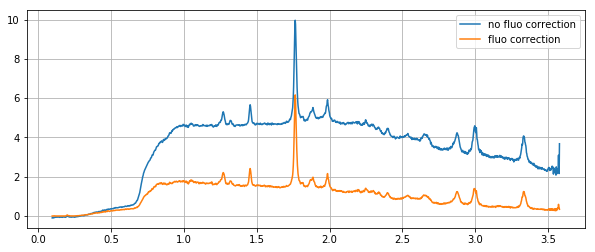

In [7]:
# do azav for 10 images, by default images are corrected (dark/gain) and filtered for fluo
# the keyword 'save' (True by default) is used to store the result at the end (to avoid aving to re-do it)
# the keyword 'force' is used to force calculation even if file is found
azav_f=jf.azav(range(30),npt_radial=1600,laser='off',force=True,save=False,energy_filter=True)
azav_nof=jf.azav(range(30),npt_radial=1600,laser='off',force=True,save=False,energy_filter=False)
fig = plt.figure(figsize=[10,4])
plt.plot(jf.q,azav_nof.mean(axis=0),label='no fluo correction')
plt.plot(jf.q,azav_f.mean(axis=0),label='fluo correction')
plt.legend()
plt.grid()

# trying to get rid of intense bragg spots

1. Start From Image
2. Calculate azimuthal averaging
3. Calculate Expected Value for each pixel $E = AZAV * POL * GEOM$, with AZAV the value of the azav for a given $q$, $POL$ is the polarization factor of a given pixel, $GEOM$ is the geometrical factor ($cos^3$)
4. Calculate 'normalized' difference image: $(IMG-E)/E$
5. add to mask all pixels that satisy the conditions $(IMG-E)/E>THRESHOLD$

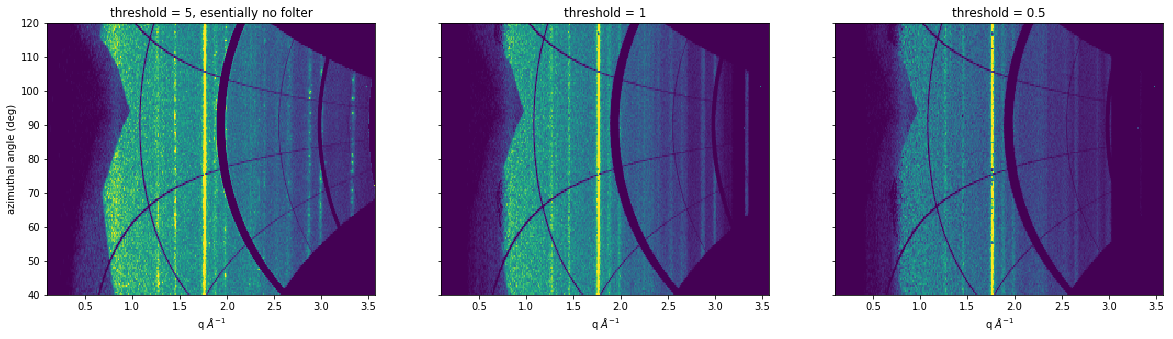

In [8]:
fig,axes = plt.subplots(1,3,figsize=[20,5],sharey=True)
imgs = jf.correct(range(30),laser='off')
img = imgs.mean(axis=0)

def do2d(img):
    return tiox.trx.azav.do2d(jf.ai,img,npt_azim=360,npt_radial=300,dark=0)

diff,mask = jf.maskFromSpikes(range(30),threshold=5)

img0 = img.copy()
img0[diff>5]=0
axes[0].pcolormesh(*do2d(img0),vmin=0,vmax=3)
axes[0].set_title("threshold = 5, esentially no folter")


img1 = img.copy()
img1[diff>1]=0
axes[1].pcolormesh(*do2d(img1),vmin=0,vmax=3)
axes[1].set_title("threshold = 1")

img2 = img.copy()
img2[diff>0.5]=0
axes[2].pcolormesh(*do2d(img2),vmin=0,vmax=3)
axes[2].set_title("threshold = 0.5")

axes[2].set_ylim(40,120)


axes[0].set_ylabel('azimuthal angle (deg)')

for ax in axes:
    ax.set_xlabel(r'q $\AA^{-1}$')



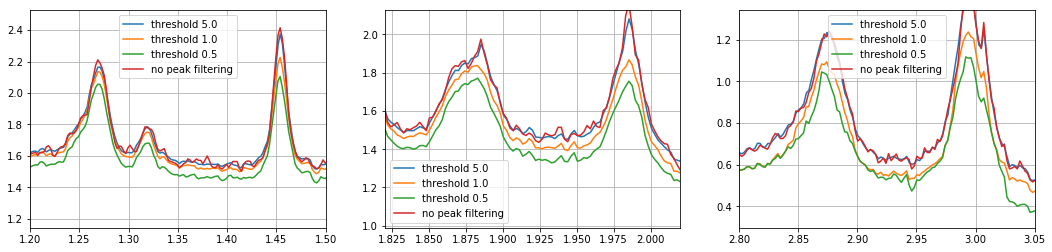

In [9]:
fig,axes = plt.subplots(1,3,figsize=[18,4])

for threshold in (5,1,0.5):
    _ = jf.maskFromSpikes(range(30),threshold=threshold); # will update internal mask
    azav=jf.azav(range(100),npt_radial=1600,laser='off',force=True,save=False)
    
    axes[0].plot(jf.q,azav.mean(axis=0),label="threshold %.1f"%threshold)
    axes[1].plot(jf.q,azav.mean(axis=0),label="threshold %.1f"%threshold)
    axes[2].plot(jf.q,azav.mean(axis=0),label="threshold %.1f"%threshold)

qranges = ( (1.2,1.5), (1.82,2.02), (2.8,3.05) )
for ax,qrange in zip(axes,qranges):
    ax.plot(jf.q,azav_f.mean(axis=0),label='no peak filtering')
    ax.set_xlim(qrange)
    ax.legend()
    ax.grid()
    # stupid matplotlib ! can't autoscale automatically
    idx = tiox.trx.utils.findSlice(jf.q,qrange)
    data_in_view = azav.mean(axis=0)[idx]
    ax.set_ylim(data_in_view.min()*0.8,data_in_view.max()*1.2)

In [10]:
print("Executing notebook took %.1f"%(time.time()-notebook_start))

Executing notebook took 75.0
